# Feed Forward Neural Network Regression with Keras

### Predict fuel efficiency (Copyright 2018 The TensorFlow Authors)

## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
path

'C:\\Users\\Milton\\.keras\\datasets\\auto-mpg.data'

Import it using pandas

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_ds = pd.read_csv(path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
ds = raw_ds.copy()
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Data cleansing

In [4]:
ds.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
ds = ds.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [6]:
ds['Origin'] = ds['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
ds = pd.get_dummies(ds, prefix='', prefix_sep='')
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
train_ds = ds.sample(frac=0.8,random_state=0)
test_ds = ds.drop(train_ds.index)

## Data analysis

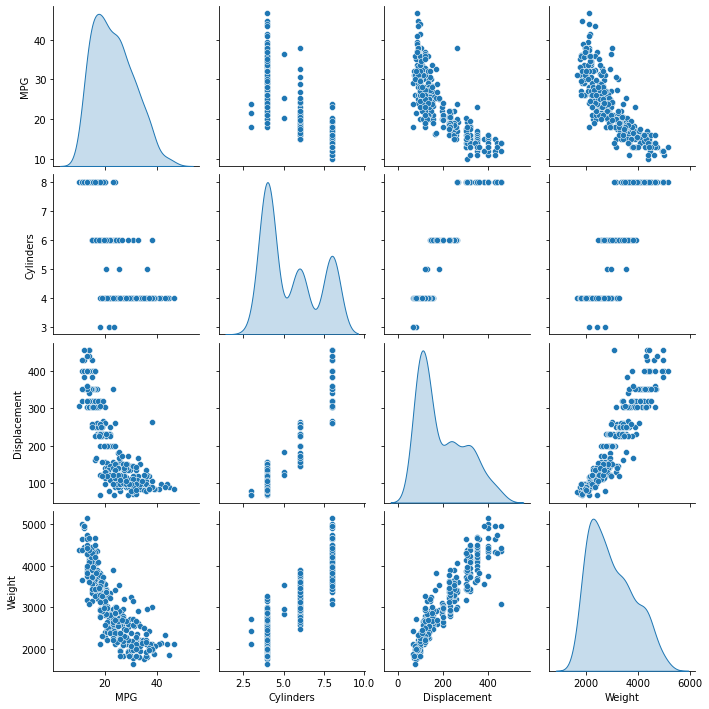

In [9]:
sns.pairplot(train_ds[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde");

Also look at the overall statistics:

In [10]:
stats = train_ds.describe()
stats.pop("MPG")
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Separate target and Normalize

In [11]:
train_labels = train_ds.pop('MPG')
test_labels = test_ds.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

In [12]:
def normalize(x):
  return (x - stats['mean']) / stats['std']

norm_train_ds = normalize(train_ds)
norm_test_ds = normalize(test_ds)

## Build Model

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_ds.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
example = norm_train_ds[:10]
model.predict(example)

array([[-0.1743806 ],
       [-0.24886289],
       [-0.24272907],
       [-0.3305452 ],
       [-0.13559896],
       [-0.22646874],
       [-0.15470847],
       [-0.20110485],
       [-0.10516337],
       [-0.06962472]], dtype=float32)

## Train

In [16]:
res = model.fit(norm_train_ds, train_labels, epochs=1000, validation_split = 0.2, verbose=1)

Epoch 1/1000
8/8 [==============================] - 0s 18ms/step - loss: 580.8600 - mae: 22.8314 - mse: 580.2433 - val_loss: 575.6088 - val_mae: 22.6879 - val_mse: 575.8884
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 536.5232 - mae: 21.8963 - mse: 538.9069 - val_loss: 535.3296 - val_mae: 21.7839 - val_mse: 535.5956
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 501.1566 - mae: 21.0479 - mse: 501.2654 - val_loss: 492.3898 - val_mae: 20.8005 - val_mse: 492.6390
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 459.7158 - mae: 20.0845 - mse: 460.5815 - val_loss: 445.6570 - val_mae: 19.6827 - val_mse: 445.8875
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 416.8131 - mae: 18.9795 - mse: 415.4539 - val_loss: 393.4998 - val_mae: 18.3678 - val_mse: 393.7064
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 364.9629 - mae: 17.6905 - mse: 365.6018 - val_loss: 337.7410 - val_

In [17]:
hist = pd.DataFrame(res.history)
hist['epoch'] = res.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.584480,0.975057,2.614240,10.889753,2.546242,10.892324,995
996,2.416206,0.962255,2.432103,10.930424,2.534935,10.927406,996
997,2.510141,1.011634,2.547432,10.859320,2.581672,10.851291,997
998,2.432683,0.972951,2.452440,10.789640,2.578132,10.780290,998
999,2.537624,0.979744,2.547396,11.203686,2.647845,11.194765,999


In [18]:
loss, mae, mse = model.evaluate(norm_test_ds, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.9235 - mae: 1.9788 - mse: 6.7178
Testing set Mean Abs Error:  1.98 MPG


## Predict

Finally, predict MPG values using data in the testing set:

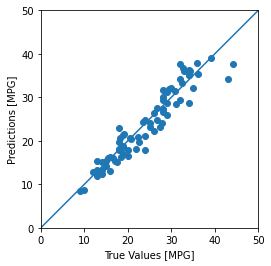

In [19]:
pred = model.predict(norm_test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


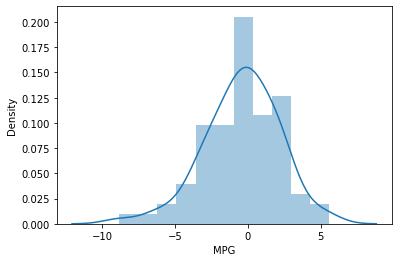

In [20]:
error = pred - test_labels
sns.distplot(error);

# Feature importance

In [67]:
Wi = model.layers[0].get_weights()

In [73]:
Wh = np.array(model.layers[1].get_weights()[0])

In [84]:
Wo = np.array(model.layers[2].get_weights()[0])

In [85]:
Wh.shape, Wo.shape

((64, 64), (64, 1))

In [90]:
def garson(Wh, Wo):
    Wo = np.diag(Wo)
    w = np.dot(Wh, Wo)
    w_h = abs(w).sum(axis=0)
    imp = np.divide(abs(w), abs(w_h))
    imp = imp.sum(axis=1)
    return imp / rc.sum()    

In [93]:
import eli5

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [97]:
perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(norm_train_ds, train_labels)
eli5.show_weights(perm, feature_names = norm_train_ds.columns.tolist())

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002290EE5C430> does not.

In [91]:
garson(Wh, Wh)

AxisError: axis 1 is out of bounds for array of dimension 1

In [76]:
Wh.shape

(64, 64)

In [66]:
for layer in model.layers: print(layer.get_config()['units'], '\n', layer.get_weights())

64 
 [array([[-1.24782510e-01,  6.01697899e-02,  2.80758649e-01,
        -2.56400406e-01, -3.55894715e-02, -3.42031479e-01,
         1.69241831e-01, -9.91712213e-02, -1.41599879e-01,
        -3.07275295e-01, -1.66868225e-01,  2.46161059e-01,
         4.51696031e-02, -2.85675284e-03, -1.04297571e-01,
        -1.50864258e-01,  5.37211597e-01, -7.08675757e-02,
        -7.32994154e-02, -6.79363236e-02,  1.38203219e-01,
        -4.16437149e-01,  2.02825814e-01,  1.08111106e-01,
        -1.21298134e-01, -3.36062849e-01,  2.41776973e-01,
         2.29977459e-01,  3.36976886e-01, -7.14954436e-02,
         1.05976611e-01, -3.64277661e-01,  2.00790212e-01,
        -9.51953009e-02,  2.85356164e-01, -2.86549866e-01,
         3.25653374e-01,  1.41140670e-01,  4.24060315e-01,
        -3.35948914e-01, -3.83645296e-01, -4.80173971e-04,
        -2.45905802e-01,  8.24809149e-02,  1.27542675e-01,
        -1.88475177e-02,  3.85518856e-02,  4.23477262e-01,
        -3.57118189e-01,  3.84044051e-01,  3.74241

## Credits & Links

https://www.tensorflow.org/tutorials/keras/regression